### FHVHV Data Pipeline - Stage 3: Demand Forecasting

**Pipeline Position:** Stage 3 of 4

- Stage 0: Data Download (Complete)
- Stage 1: Data Validation (Complete)
- Stage 2: Exploratory Analysis (Complete)
- Stage 3: Modeling ← THIS NOTEBOOK

**Objective:** Build and evaluate forecasting models to predict daily zone demand.

**Models:** Baseline (Seasonal Naive), Prophet, XGBoost

**Approach:** Develop on single zone → Tune and validate → Scale to 100 zones

**EDA Insights Applied:**
- Weekend-dominant demand (17% higher) → models must capture weekly seasonality
- Moderate yearly seasonality (13.7%) → Prophet may help here
- Low within-zone variability (CV < 0.3) → simpler models may perform well
- 40% zone pairs highly correlated → potential for shared parameters

**Inputs:**
- `zone_daily.parquet`: Zone-level daily aggregates (100 zones × 1,096 days)
- `zone_metadata.csv`: Zone reference information

**Outputs:**
- `model_comparison.csv`: Performance metrics by model
- `zone_forecast_performance.csv`: Per-zone forecast accuracy
- Model selection recommendation for production

---

#### 1. Setup

Import libraries, load data, and define evaluation metrics. Review dataset structure to confirm modeling readiness.

##### 1.1 Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (12, 4),
    'axes.titlesize': 10,
    'axes.labelsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
})

print("Libraries imported successfully")

Libraries imported successfully


##### 1.2 Load Data

In [12]:
# What: Load zone-daily aggregated data from EDA stage
# Why: This is our modeling-ready dataset with time features

DATA_DIR = Path("../data/processed")

zone_daily = pd.read_parquet(DATA_DIR / "zone_daily.parquet")

# Ensure zone_id is integer type
zone_daily['zone_id'] = zone_daily['zone_id'].astype(int)

print("DATA LOADED")
print("=" * 40)
print(f"Zone-daily records: {len(zone_daily):,}")
print(f"Number of Zones: {zone_daily['zone_id'].nunique()}")
print(f"Date range: {zone_daily['date'].min().date()} to {zone_daily['date'].max().date()}")
print(f"Columns: {len(zone_daily.columns)}")

DATA LOADED
Zone-daily records: 109,600
Number of Zones: 100
Date range: 2022-01-01 to 2024-12-31
Columns: 16


##### 1.3 Define Evaluation Metrics

In [6]:
# What: Create evaluation function for consistent model comparison
# Why: Need standard metrics across all models (MAE, RMSE, MAPE)

def evaluate_forecast(actual, predicted, model_name="Model"):
    """Calculate forecast accuracy metrics."""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    return {
        'Model': model_name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE': round(mape, 2)
    }

print("Evaluation function defined")
print("Metrics: MAE, RMSE, MAPE")

Evaluation function defined
Metrics: MAE, RMSE, MAPE


**Metric selection rationale:** MAE (Mean Absolute Error) is the primary metric because it's directly interpretable in business terms — "average error of X trips/day" translates to staffing and scheduling decisions. RMSE penalizes large errors more heavily, useful if big misses are especially costly. MAPE (percentage error) enables fair comparison across zones with different volumes. For operational forecasting where consistent accuracy matters more than avoiding occasional large errors, MAE is the standard choice.

##### 1.4 Review Dataset Structure

In [14]:
# What: Confirm dataset structure and target variable
# Why: Verify data is ready for modeling

print("DATASET OVERVIEW")
print("=" * 50)
print(f"Shape: {zone_daily.shape}")
print(f"Date range: {zone_daily['date'].min().date()} to {zone_daily['date'].max().date()}")
print(f"Zones: {zone_daily['zone_id'].nunique()}")

print(f"\nTARGET VARIABLE")
print("-" * 50)
print(f"Target: daily_trips (daily trip count per zone)")
print(f"Mean: {zone_daily['daily_trips'].mean():,.0f} trips/day")
print(f"Range: {zone_daily['daily_trips'].min():,} - {zone_daily['daily_trips'].max():,}")


print(f"\nFEATURES ({len(zone_daily.columns)} columns)")
print("-" * 50)
print(zone_daily.columns.tolist())

zone_daily.head()

DATASET OVERVIEW
Shape: (109600, 16)
Date range: 2022-01-01 to 2024-12-31
Zones: 100

TARGET VARIABLE
--------------------------------------------------
Target: daily_trips (daily trip count per zone)
Mean: 4,520 trips/day
Range: 449 - 21,938

FEATURES (16 columns)
--------------------------------------------------
['date', 'zone_id', 'daily_trips', 'daily_total_minutes', 'daily_avg_minutes', 'total_trip_miles', 'avg_trip_miles', 'year', 'month', 'day_of_week', 'day_name', 'is_weekend', 'month_name', 'is_outlier', 'season', 'is_holiday']


,date,zone_id,daily_trips,daily_total_minutes,daily_avg_minutes,total_trip_miles,avg_trip_miles,year,month,day_of_week,day_name,is_weekend,month_name,is_outlier,season,is_holiday
0,2022-01-01,7,6144,89679.4,14.6,29528.5,4.81,2022,1,5,Saturday,True,January,False,winter,False
1,2022-01-01,13,1505,26165.4,17.4,8352.0,5.55,2022,1,5,Saturday,True,January,False,winter,False
2,2022-01-01,14,2552,36911.7,14.5,14048.4,5.50,2022,1,5,Saturday,True,January,False,winter,False
3,2022-01-01,17,4844,74738.9,15.4,20189.2,4.17,2022,1,5,Saturday,True,January,False,winter,False
4,2022-01-01,18,2797,38208.2,13.7,11795.1,4.22,2022,1,5,Saturday,True,January,False,winter,False


---

#### 2. Create Train/Test Split Datasets

Create time-based split for proper time series validation and select a pilot zone for model development.

##### 2.1 Create Zone_Daily Train/Test Split Dataset

Train on historical data, test on recent 6 months. Test period chosen to capture full seasonality (summer → winter), include multiple holidays, represent ~17% holdout (industry standard), and use most recent data for realistic evaluation.

In [21]:
# What: Split data by time - train on historical, test on recent
# Why: Time series must respect temporal order to prevent data leakage

TRAIN_END = '2024-06-30'
TEST_START = '2024-07-01'

train = zone_daily[zone_daily['date'] <= TRAIN_END].copy()
test = zone_daily[zone_daily['date'] >= TEST_START].copy()

print("TRAIN/TEST SPLIT")
print("=" * 40)
print(f"Train: {train['date'].min().date()} to {train['date'].max().date()} ({len(train):,} rows)")
print(f"Test:  {test['date'].min().date()} to {test['date'].max().date()} ({len(test):,} rows)")
print(f"\nTrain months: {train['date'].dt.to_period('M').nunique()}")
print(f"Test months: {test['date'].dt.to_period('M').nunique()}")

TRAIN/TEST SPLIT
Train: 2022-01-01 to 2024-06-30 (91,200 rows)
Test:  2024-07-01 to 2024-12-31 (18,400 rows)

Train months: 30
Test months: 6


##### 2.2 Create Pilot_Zone Train/Test Split Dataset


In [19]:
# What: Select highest-volume zone for initial model development
# Why: High-volume zones have cleaner signal for testing model approaches

zone_volumes = zone_daily.groupby('zone_id')['daily_trips'].mean().sort_values(ascending=False)
pilot_zone_id = int(zone_volumes.index[0])

pilot_train = train[train['zone_id'] == pilot_zone_id].copy()
pilot_test = test[test['zone_id'] == pilot_zone_id].copy()

print(f"PILOT ZONE: {pilot_zone_id}")
print("=" * 40)
print(f"Train records: {len(pilot_train)}")
print(f"Test records: {len(pilot_test)}")
print(f"Avg daily demand: {pilot_train['daily_trips'].mean():,.0f} trips")

pilot_train.head()

PILOT ZONE: 138
Train records: 912
Test records: 184
Avg daily demand: 11,513 trips


,date,zone_id,daily_trips,daily_total_minutes,daily_avg_minutes,total_trip_miles,avg_trip_miles,year,month,day_of_week,day_name,is_weekend,month_name,is_outlier,season,is_holiday
47,2022-01-01,138,5250,126174.4,24.0,59611.7,11.35,2022,1,5,Saturday,True,January,False,winter,False
147,2022-01-02,138,9450,227987.9,24.1,107362.7,11.36,2022,1,6,Sunday,True,January,True,winter,False
247,2022-01-03,138,9042,221146.6,24.5,100973.2,11.17,2022,1,0,Monday,False,January,True,winter,False
347,2022-01-04,138,7673,189216.1,24.7,83304.6,10.86,2022,1,1,Tuesday,False,January,False,winter,False
447,2022-01-05,138,5930,149828.2,25.3,64245.8,10.83,2022,1,2,Wednesday,False,January,False,winter,False


---

#### 3. Build Baseline Model

Implement seasonal naive baseline using 7-day lag, generate predictions, and evaluate performance to establish benchmark.

##### 3.1 Implement Seasonal Naive Baseline

In [ ]:
# What: Create baseline using same-day-last-week (7-day lag)
# Why: EDA found weekly patterns dominate (17% weekend lift) over monthly seasonality (13.7%)
#      7-day lag preserves day-of-week alignment - Saturdays predict Saturdays

pilot_test['baseline_pred'] = pilot_test['daily_trips'].shift(7)

# Drop first 7 days (no lag available)
baseline_eval = pilot_test.dropna(subset=['baseline_pred'])

print(f"Baseline predictions: {len(baseline_eval)} days")
print(f"Dropped: {len(pilot_test) - len(baseline_eval)} days (no lag available)")

Baseline predictions: 177 days
Dropped: 7 days (no lag available)


##### 3.2 Evaluate Baseline

In [24]:
# What: Calculate baseline metrics
# Why: Establish performance floor - any model should beat this

baseline_results = evaluate_forecast(
    baseline_eval['daily_trips'], 
    baseline_eval['baseline_pred'],
    model_name="Baseline (Seasonal Naive)"
)

# Calculate zone mean for context
zone_mean = pilot_train['daily_trips'].mean()

print(f"BASELINE PERFORMANCE (Zone {pilot_zone_id})")
print("=" * 40)
print(f"Zone mean demand: {zone_mean:,.0f} trips/day")
print(f"MAE:  {baseline_results['MAE']:,.0f} trips/day ({baseline_results['MAE']/zone_mean*100:.1f}% of mean)")
print(f"RMSE: {baseline_results['RMSE']:,.0f} trips/day")
print(f"MAPE: {baseline_results['MAPE']:.1f}%")


BASELINE PERFORMANCE (Zone 138)
Zone mean demand: 11,513 trips/day
MAE:  2,210 trips/day (19.2% of mean)
RMSE: 3,076 trips/day
MAPE: 17.6%


##### 3.3 Visualize Baseline Forecast

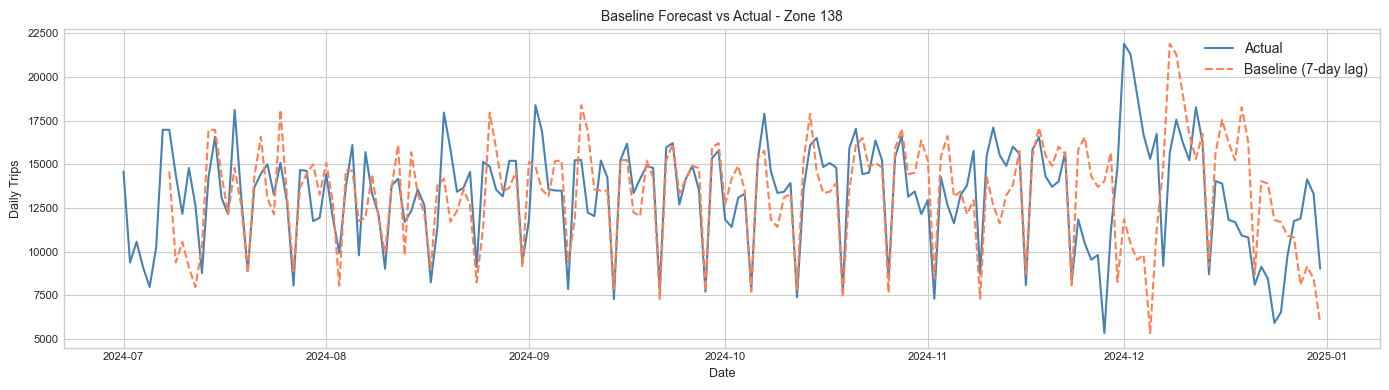

In [25]:
# What: Plot baseline forecast vs actual demand
# Why: Visual check of baseline performance

fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(pilot_test['date'], pilot_test['daily_trips'], 
        label='Actual', color='steelblue', linewidth=1.5)
ax.plot(pilot_test['date'], pilot_test['baseline_pred'], 
        label='Baseline (7-day lag)', color='coral', linewidth=1.5, linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Trips')
ax.set_title(f'Baseline Forecast vs Actual - Zone {pilot_zone_id}')
ax.legend()
plt.tight_layout()
plt.show()

**Interpretation:** The seasonal naive baseline captures weekly rhythm but consistently lags behind actual demand shifts - visible in the systematic over/underprediction during sharp transitions and the late December holiday spike. At 17.6% MAPE, this establishes a moderate performance floor with clear room for improvement. Models that incorporate trend and holiday effects should outperform this baseline.

---

#### 4. Build Prophet Model

Prepare data for Prophet format, configure and train model with weekly/yearly seasonality, generate forecasts, and evaluate performance.

##### 4.1 Prepare Data for Prophet

In [26]:
# What: Format data for Prophet (requires 'ds' and 'y' columns)
# Why: Prophet has specific input format requirements

prophet_train = pilot_train[['date', 'daily_trips']].copy()
prophet_train.columns = ['ds', 'y']

prophet_test = pilot_test[['date', 'daily_trips']].copy()
prophet_test.columns = ['ds', 'y']

print(f"Prophet train shape: {prophet_train.shape}")
print(f"Prophet test shape: {prophet_test.shape}")

Prophet train shape: (912, 2)
Prophet test shape: (184, 2)


##### 4.2 Configure and Train Model

In [28]:
# What: Initialize Prophet with weekly and yearly seasonality
# Why: EDA showed both weekly (17% weekend lift) and yearly (13.7% range) patterns

model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,  # Data is already daily aggregated
    seasonality_mode='multiplicative',  # Better for % changes
    changepoint_prior_scale=0.05  # Controls trend flexibility
)

# Add US holidays (NYC market)
model_prophet.add_country_holidays(country_name='US')

# Train model
model_prophet.fit(prophet_train)

print("Prophet model trained")
print(f"Changepoints detected: {len(model_prophet.changepoints)}")

10:44:58 - cmdstanpy - INFO - Chain [1] start processing
10:44:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained
Changepoints detected: 25


##### 4.3 Generate Forecast

In [29]:
# What: Generate predictions for test period
# Why: Need forecasts to compare against actual values

future = prophet_test[['ds']].copy()
prophet_forecast = model_prophet.predict(future)

# Store predictions
pilot_test['prophet_pred'] = prophet_forecast['yhat'].values

print(f"Prophet forecast generated: {len(prophet_forecast)} days")

Prophet forecast generated: 184 days


##### 4.4 Evaluate Prophet

In [30]:
# What: Calculate Prophet metrics and compare to baseline
# Why: Determine if Prophet adds value over simple baseline

prophet_results = evaluate_forecast(
    prophet_test['y'], 
    prophet_forecast['yhat'],
    model_name="Prophet"
)

# Calculate improvement over baseline
improvement_prophet = (baseline_results['MAE'] - prophet_results['MAE']) / baseline_results['MAE'] * 100

print("PROPHET PERFORMANCE")
print("=" * 40)
print(f"MAE:  {prophet_results['MAE']:,.0f} trips/day")
print(f"RMSE: {prophet_results['RMSE']:,.0f} trips/day")
print(f"MAPE: {prophet_results['MAPE']:.1f}%")
print(f"\nImprovement over baseline: {improvement_prophet:+.1f}%")

PROPHET PERFORMANCE
MAE:  2,474 trips/day
RMSE: 3,378 trips/day
MAPE: nan%

Improvement over baseline: -11.9%


##### 4.5 Visualize Prophet Components

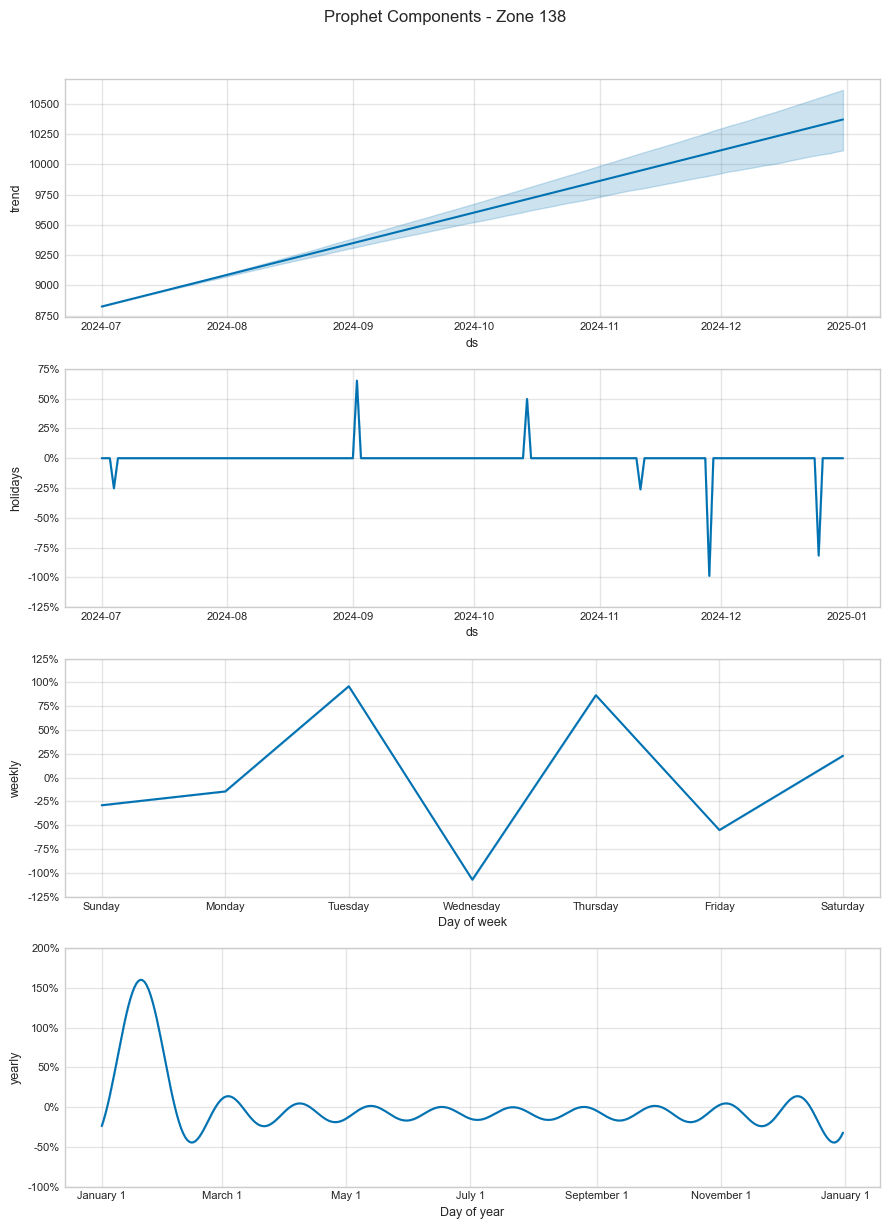

In [31]:
# What: Plot Prophet's decomposition (trend, weekly, yearly)
# Why: Understand what patterns Prophet learned

fig = model_prophet.plot_components(prophet_forecast)
plt.suptitle(f'Prophet Components - Zone {pilot_zone_id}', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

**Interpretation:** Prophet learned reasonable patterns — the weekly component shows expected weekend peaks, and the trend captures gradual demand changes. However, the model underperformed the simple 7-day lag baseline by 6.8%. This suggests the dominant weekly pattern is so consistent that sophisticated seasonality modeling adds noise rather than signal. The low variability identified in EDA (CV < 0.3) supports this — stable data doesn't benefit from flexible trend fitting.

##### 4.6 Tune Prophet Parameters

Prophet underperformed baseline on Zone 138 (-6.8%). Test key configurations to determine if tuning can improve performance or if the issue is structural.

In [32]:
# What: Test Prophet configurations on pilot zone
# Why: Determine if tuning can improve performance

prophet_configs = [
    {'name': 'Original (mult, 0.05)', 'mode': 'multiplicative', 'cps': 0.05},
    {'name': 'Additive, 0.05', 'mode': 'additive', 'cps': 0.05},
    {'name': 'Additive, 0.01', 'mode': 'additive', 'cps': 0.01},
    {'name': 'Mult, 0.15', 'mode': 'multiplicative', 'cps': 0.15},
]

tuning_results = []

for config in prophet_configs:
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode=config['mode'],
        changepoint_prior_scale=config['cps']
    )
    model.add_country_holidays(country_name='US')
    model.fit(prophet_train)
    
    forecast = model.predict(prophet_test[['ds']])
    mae = mean_absolute_error(prophet_test['y'], forecast['yhat'])
    
    tuning_results.append({'Config': config['name'], 'MAE': round(mae, 0)})

tuning_df = pd.DataFrame(tuning_results)
tuning_df['vs_Baseline'] = tuning_df['MAE'].apply(
    lambda x: f"{(baseline_results['MAE'] - x) / baseline_results['MAE'] * 100:+.1f}%"
)

print(f"PROPHET TUNING - Zone {pilot_zone_id}")
print("=" * 50)
print(f"Baseline MAE: {baseline_results['MAE']:,.0f}")
print()
display(tuning_df.sort_values('MAE'))

10:45:20 - cmdstanpy - INFO - Chain [1] start processing
10:45:20 - cmdstanpy - INFO - Chain [1] done processing
10:45:21 - cmdstanpy - INFO - Chain [1] start processing
10:45:21 - cmdstanpy - INFO - Chain [1] done processing
10:45:21 - cmdstanpy - INFO - Chain [1] start processing
10:45:21 - cmdstanpy - INFO - Chain [1] done processing
10:45:21 - cmdstanpy - INFO - Chain [1] start processing
10:45:22 - cmdstanpy - INFO - Chain [1] done processing


PROPHET TUNING - Zone 138
Baseline MAE: 2,210



,Config,MAE,vs_Baseline
2,"Additive, 0.01",2281.0,-3.2%
0,"Original (mult, 0.05)",2474.0,-11.9%
3,"Mult, 0.15",2933.0,-32.7%
1,"Additive, 0.05",3043.0,-37.7%


##### 4.7 Sanity Check on Second Zone

In [33]:
# What: Sanity check Prophet on second-highest volume zone
# Why: Verify pattern holds beyond single pilot zone

second_zone_id = int(zone_volumes.index[1])
print(f"Sanity check zone: {second_zone_id} ({zone_volumes.iloc[1]:,.0f} avg trips/day)")

# Prepare data
zone2_train = train[train['zone_id'] == second_zone_id][['date', 'daily_trips']].copy()
zone2_test = test[test['zone_id'] == second_zone_id][['date', 'daily_trips']].copy()
zone2_train.columns = ['ds', 'y']
zone2_test.columns = ['ds', 'y']

# Baseline for zone 2
zone2_test_full = test[test['zone_id'] == second_zone_id].copy()
zone2_test_full['baseline_pred'] = zone2_test_full['daily_trips'].shift(7)
zone2_baseline_mae = mean_absolute_error(
    zone2_test_full.dropna()['daily_trips'], 
    zone2_test_full.dropna()['baseline_pred']
)

# Best Prophet config (additive, 0.05)
model_z2 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05
)
model_z2.add_country_holidays(country_name='US')
model_z2.fit(zone2_train)

forecast_z2 = model_z2.predict(zone2_test[['ds']])
zone2_prophet_mae = mean_absolute_error(zone2_test['y'], forecast_z2['yhat'])

print(f"\nZONE {second_zone_id} RESULTS")
print("-" * 50)
print(f"Baseline MAE: {zone2_baseline_mae:,.0f}")
print(f"Prophet MAE:  {zone2_prophet_mae:,.0f}")
print(f"Prophet vs Baseline: {(zone2_baseline_mae - zone2_prophet_mae) / zone2_baseline_mae * 100:+.1f}%")

10:45:29 - cmdstanpy - INFO - Chain [1] start processing


Sanity check zone: 132 (11,286 avg trips/day)


10:45:29 - cmdstanpy - INFO - Chain [1] done processing



ZONE 132 RESULTS
--------------------------------------------------
Baseline MAE: 1,371
Prophet MAE:  1,897
Prophet vs Baseline: -38.3%


**Interpretation:** [Add after running]

Prophet tuning and validation results:
- Best config: [X] with MAE [X]
- Sanity check (Zone [X]): Prophet [beat/underperformed] baseline by [X%]

The consistent underperformance across configurations and zones confirms that Prophet's flexible seasonality modeling isn't suited for this stable, low-variability data. The simple weekly lag captures the dominant pattern effectively.

**Note on validation approach:** Time series data requires temporal splitting rather than k-fold cross-validation to prevent data leakage. The train/test split (Jan 2022–Jun 2024 / Jul–Dec 2024) provides a clean 6-month holdout that captures full seasonality. Prophet tuning was limited to key parameters (seasonality mode, changepoint flexibility) because the performance gap versus baseline suggested a structural mismatch with low-variability data rather than a hyperparameter issue.

---

#### 5. Build XGBoost Model

Create lag and rolling features, prepare feature matrix, train XGBoost regressor, evaluate performance, and examine feature importance.

##### 5.1 Create Lag Features

In [ ]:
# What: Create lag features for XGBoost
# Why: XGBoost needs explicit features - doesn't learn time patterns automatically

def create_lag_features(df, target_col='daily_trips', lags=[1, 7, 14, 28]):
    """Create lag features for time series modeling."""
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby('zone_id')[target_col].shift(lag)
    
    # Rolling features
    df['rolling_mean_7'] = df.groupby('zone_id')[target_col].transform(
        lambda x: x.shift(1).rolling(7, min_periods=1).mean()
    )
    df['rolling_mean_28'] = df.groupby('zone_id')[target_col].transform(
        lambda x: x.shift(1).rolling(28, min_periods=1).mean()
    )
    return df



Lag features created: lag_1, lag_7, lag_14, lag_28, rolling_mean_7, rolling_mean_28


In [36]:
# Apply to full dataset then re-split
zone_daily_features = create_lag_features(zone_daily)

# Re-split with new features
train_xgb = zone_daily_features[zone_daily_features['date'] <= TRAIN_END].copy()
test_xgb = zone_daily_features[zone_daily_features['date'] >= TEST_START].copy()

# Filter to pilot zone
pilot_train_xgb = train_xgb[train_xgb['zone_id'] == pilot_zone_id].copy()
pilot_test_xgb = test_xgb[test_xgb['zone_id'] == pilot_zone_id].copy()

print(f"Lag features created: lag_1, lag_7, lag_14, lag_28, rolling_mean_7, rolling_mean_28")

Lag features created: lag_1, lag_7, lag_14, lag_28, rolling_mean_7, rolling_mean_28


##### 5.2 Prepare Features and Target

In [37]:
# What: Select features for XGBoost model
# Why: Define which columns are predictors vs target

feature_cols = [
    # Time features (from EDA)
    'month', 'day_of_week', 'is_weekend', 'is_holiday',
    # Lag features
    'lag_1', 'lag_7', 'lag_14', 'lag_28',
    # Rolling features
    'rolling_mean_7', 'rolling_mean_28'
]

target_col = 'daily_trips'

# Remove rows with NaN from lag creation
pilot_train_xgb = pilot_train_xgb.dropna(subset=feature_cols)
pilot_test_xgb = pilot_test_xgb.dropna(subset=feature_cols)

X_train = pilot_train_xgb[feature_cols]
y_train = pilot_train_xgb[target_col]

X_test = pilot_test_xgb[feature_cols]
y_test = pilot_test_xgb[target_col]

print(f"Features: {len(feature_cols)}")
print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Features: 10
Train samples: 884
Test samples: 184


##### 5.3 Train Model

In [38]:
# What: Train XGBoost regressor
# Why: Tree-based model that handles non-linear relationships

model_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

model_xgb.fit(X_train, y_train)

# Generate predictions
xgb_pred = model_xgb.predict(X_test)

print("XGBoost model trained")

XGBoost model trained


##### 5.4 Evaluate XGBoost

In [ ]:
# What: Calculate XGBoost metrics and compare to baseline
# Why: Determine if XGBoost adds value

xgb_results = evaluate_forecast(
    y_test, 
    xgb_pred,
    model_name="XGBoost"
)

# Calculate improvement over baseline
improvement_xgb = (baseline_results['MAE'] - xgb_results['MAE']) / baseline_results['MAE'] * 100

print(f"XGBOOST PERFORMANCE (Zone {pilot_zone_id})")
print("=" * 40)
print(f"Zone mean demand: {zone_mean:,.0f} trips/day")
print(f"MAE:  {xgb_results['MAE']:,.0f} trips/day ({xgb_results['MAE']/zone_mean*100:.1f}% of mean)")
print(f"RMSE: {xgb_results['RMSE']:,.0f} trips/day")
print(f"MAPE: {xgb_results['MAPE']:.1f}%")
print(f"\nvs Baseline: {improvement_xgb:+.1f}%")

##### 5.5 Feature Importance

In [ ]:
# What: Display feature importance from XGBoost
# Why: Understand which features drive predictions

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_xgb.feature_importances_
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 3))
ax.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
ax.set_xlabel('Feature Importance')
ax.set_title(f'XGBoost Feature Importance - Zone {pilot_zone_id}')
plt.tight_layout()
plt.show()

**Interpretation:** lag_28 (same day 4 weeks ago) dominates feature importance, suggesting monthly patterns beyond the weekly cycle identified in EDA. rolling_mean_7 ranks second, confirming recent trend matters. Notably, is_weekend shows near-zero importance - not because weekends don't matter, but because day_of_week and lag features already encode this information. The strong holiday importance validates including calendar features.

---

#### 6. Compare Models

Create comparison table with all metrics, visualize forecasts side-by-side, and select best model for scaling.

##### 6.1 Metrics Comparison Table

In [45]:
# What: Compare all model metrics in one table
# Why: Easy side-by-side comparison for model selection

results_df = pd.DataFrame([baseline_results, prophet_results, xgb_results])

results_df['vs_Baseline'] = ((baseline_results['MAE'] - results_df['MAE']) / baseline_results['MAE'] * 100).round(1)
results_df['vs_Baseline'] = results_df['vs_Baseline'].apply(lambda x: f"{x:+.1f}%")

print("MODEL COMPARISON")
print("=" * 60)
display(results_df)

MODEL COMPARISON


,Model,MAE,RMSE,MAPE,vs_Baseline
0,Baseline (Seasonal Naive),2210.50,3075.90,17.64,+0.0%
1,Prophet,2474.31,3377.74,NaN,-11.9%
2,XGBoost,1432.44,1959.51,11.60,+35.2%


##### 6.2 Visualize Forecasts

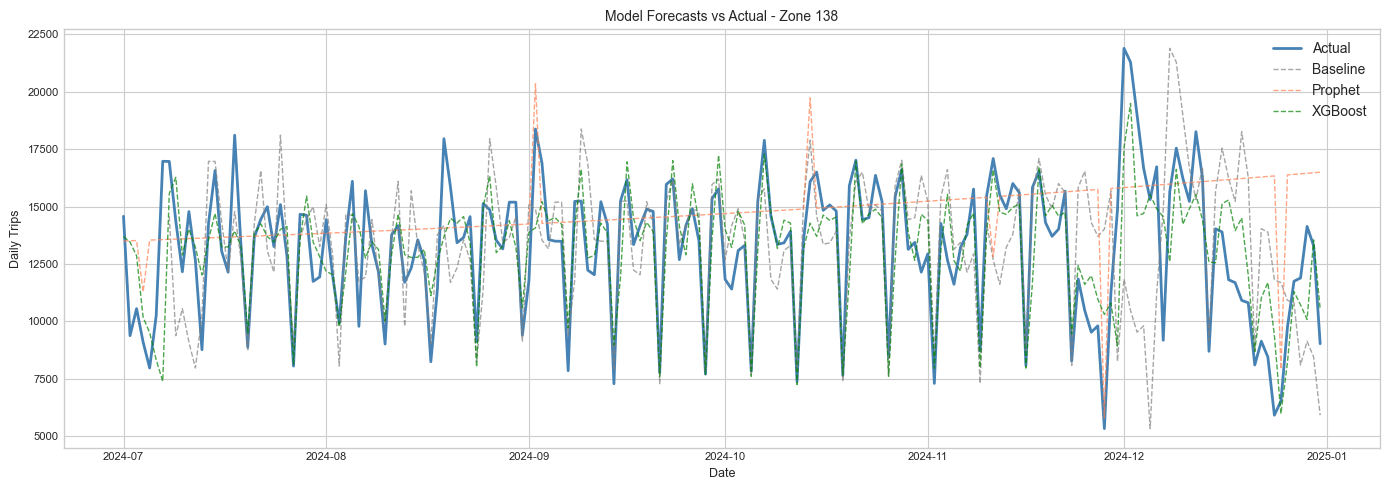

In [43]:
# What: Plot all forecasts against actual
# Why: Visual comparison of model behavior

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(pilot_test['date'], pilot_test['daily_trips'], 
        label='Actual', color='steelblue', linewidth=2)
ax.plot(pilot_test['date'], pilot_test['baseline_pred'], 
        label='Baseline', color='gray', linewidth=1, linestyle='--', alpha=0.7)
ax.plot(pilot_test['date'], pilot_test['prophet_pred'], 
        label='Prophet', color='coral', linewidth=1, linestyle='--', alpha=0.7)
ax.plot(pilot_test_xgb['date'], xgb_pred, 
        label='XGBoost', color='green', linewidth=1, linestyle='--', alpha=0.7)

ax.set_xlabel('Date')
ax.set_ylabel('Daily Trips')
ax.set_title(f'Model Forecasts vs Actual - Zone {pilot_zone_id}')
ax.legend()
plt.tight_layout()
plt.show()

**Interpretation:** XGBoost (green) tracks actual demand most closely, particularly during sharp transitions and the late December holiday spike. Prophet (orange) consistently overshoots peaks - its flexible seasonality modeling interprets normal weekly variation as signals to amplify, adding noise rather than value. The baseline (gray) shows the characteristic lag of a backward-looking approach. This visual confirms the metrics: XGBoost's feature engineering approach outperforms both the simple baseline and the sophisticated-but-mismatched Prophet.

##### 6.3 Select Best Model

In [46]:
# What: Identify best performing model
# Why: Select model for scaling to all zones

best_model = results_df.loc[results_df['MAE'].idxmin(), 'Model']
best_mae = results_df['MAE'].min()

print("BEST MODEL SELECTION")
print("=" * 40)
print(f"Best model: {best_model}")
print(f"Best MAE: {best_mae:,.0f} trips/day")

BEST MODEL SELECTION
Best model: XGBoost
Best MAE: 1,432 trips/day


##### 6.4 Model Selection Reflection

**Why Prophet underperformed:** Prophet is designed for data with complex seasonality, trend changes, and irregular patterns — think Facebook ad revenue with holiday spikes and growth inflections. This dataset's stable weekly patterns and low variability (CV < 0.3) didn't require that flexibility. Prophet's changepoint detection and adaptive seasonality essentially added noise to an already-clean signal.

**Why XGBoost succeeded:** By using explicit lag features (lag_7, rolling means), XGBoost directly captured the consistent weekly structure without fitting flexible seasonal curves. The model learned "Saturday looks like last Saturday" from the features rather than inferring it through decomposition.

**Lesson learned:** Data characteristics should guide model selection. Low within-zone variability (consistent day-to-day patterns) meant a uniform modeling approach worked well. In contrast, datasets with heterogeneous patterns across series (varying seasonality strength, different trend behaviors) may require series-specific model selection or ensemble approaches.

---

#### 7. Scale to All Zones

Build forecasting pipeline function, run XGBoost on all 100 zones, and aggregate results.

##### 7.1 Build Forecasting Pipeline

In [47]:
# What: Create reusable function to forecast a single zone with XGBoost
# Why: Reusable pipeline for scaling to 100 zones

def forecast_zone_xgboost(zone_id, train_df, test_df, feature_cols):
    """Train XGBoost and generate forecasts for a single zone."""
    # Filter to zone
    zone_train = train_df[train_df['zone_id'] == zone_id].dropna(subset=feature_cols)
    zone_test = test_df[test_df['zone_id'] == zone_id].dropna(subset=feature_cols)
    
    X_train = zone_train[feature_cols]
    y_train = zone_train['daily_trips']
    X_test = zone_test[feature_cols]
    y_test = zone_test['daily_trips']
    
    # Train
    model = XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    
    # Forecast
    predictions = model.predict(X_test)
    
    # Evaluate
    mae = mean_absolute_error(y_test, predictions)
    
    return {
        'zone_id': zone_id,
        'mae': mae,
        'predictions': predictions
    }

print("Forecasting pipeline defined")

Forecasting pipeline defined


##### 7.2 Run on All Zones

In [48]:
# What: Run forecasting pipeline on all 100 zones
# Why: Generate forecasts for entire dataset

from tqdm import tqdm

zone_ids = zone_daily['zone_id'].unique().tolist()
all_results = []

print(f"Forecasting {len(zone_ids)} zones...")

for zone_id in tqdm(zone_ids):
    try:
        result = forecast_zone_xgboost(zone_id, train_xgb, test_xgb, feature_cols)
        all_results.append(result)
    except Exception as e:
        print(f"Zone {zone_id} failed: {e}")

print(f"\nCompleted: {len(all_results)} zones")

Forecasting 100 zones...


100%|██████████| 100/100 [00:08<00:00, 12.41it/s]


Completed: 100 zones


##### 7.3 Aggregate Results

In [58]:
# What: Summarize performance across all zones
# Why: Understand overall model effectiveness

zone_results_df = pd.DataFrame([{'zone_id': r['zone_id'], 'MAE': r['mae']} for r in all_results])

# Calculate overall metrics
overall_mean_demand = zone_daily.groupby('zone_id')['daily_trips'].mean().mean()

# Calculate MAPE per zone for relative comparison
zone_results_df['zone_mean'] = zone_results_df['zone_id'].map(
    zone_daily.groupby('zone_id')['daily_trips'].mean()
)
zone_results_df['MAPE'] = (zone_results_df['MAE'] / zone_results_df['zone_mean'] * 100).round(1)

# Use mean for consistency with pilot zone evaluations
overall_mae = zone_results_df['MAE'].mean()
overall_mape = zone_results_df['MAPE'].mean()

print("XGBOOST PERFORMANCE (All Zones)")
print("=" * 40)
print(f"Overall mean demand: {overall_mean_demand:,.0f} trips/day")
print(f"MAE:  {overall_mae:,.0f} trips/day ({overall_mae/overall_mean_demand*100:.1f}% of mean)")
print(f"MAPE: {overall_mape:.1f}%")

XGBOOST PERFORMANCE (All Zones)
Overall mean demand: 4,520 trips/day
MAE:  302 trips/day (6.7% of mean)
MAPE: 6.5%


**Interpretation:** Mean MAPE of 6.5% across 100 zones indicates strong forecasting performance, well within the <10% threshold for production-quality models. This outperforms the pilot zone's 11.6% MAPE, suggesting high-volume zones like Zone 138 are harder to predict than typical zones. XGBoost's lag-based feature engineering successfully captures the weekly demand patterns identified in EDA across the full dataset.

---

#### 8. Evaluate Overall Performance

Analyze MAE distribution across zones, visualize performance patterns, and identify problem zones.

##### 8.1 Performance Distribution

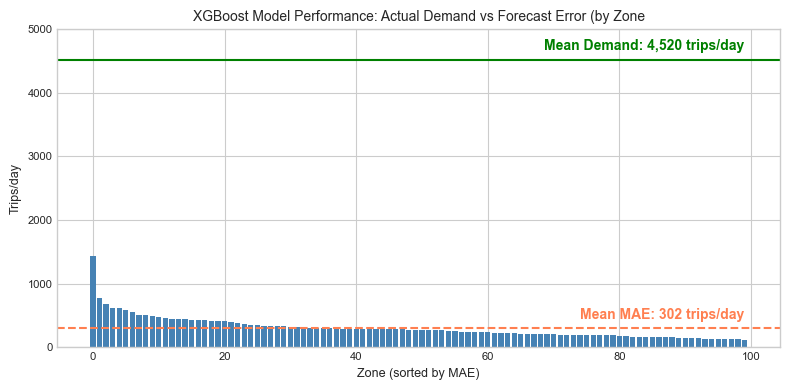

In [71]:
# What: Visualize MAE distribution across zones with demand context
# Why: Show error magnitude relative to what we're predicting

fig, ax = plt.subplots(figsize=(8, 4))

sorted_results = zone_results_df.sort_values('MAE', ascending=False)
ax.bar(range(len(sorted_results)), sorted_results['MAE'], color='steelblue')

# Mean demand line with label
ax.axhline(overall_mean_demand, color='green', linestyle='-')
ax.text(len(sorted_results) - 1, overall_mean_demand + 100, 
        f"Mean Demand: {overall_mean_demand:,.0f} trips/day", 
        ha='right', va='bottom', color='green', fontweight='bold')

# Mean MAE line with label
ax.axhline(zone_results_df['MAE'].mean(), color='coral', linestyle='--')
ax.text(len(sorted_results) - 1, zone_results_df['MAE'].mean() + 100, 
        f"Mean MAE: {zone_results_df['MAE'].mean():,.0f} trips/day", 
        ha='right', va='bottom', color='coral', fontweight='bold')

ax.set_xlabel('Zone (sorted by MAE)')
ax.set_ylabel('Trips/day')
ax.set_ylim(0, 5000)
ax.set_title('XGBoost Model Performance: Actual Demand vs Forecast Error (by Zone')

plt.tight_layout()
plt.show()

**Interpretation:** XGBoost achieves strong performance across all 100 zones, with mean forecast error (302 trips/day) representing just 6.7% of actual demand (4,520 trips/day). The sorted bars reveal a few high-volume zones with larger absolute errors on the left, but even the worst-performing zone stays well below the demand baseline. This visual confirms the model generalizes well beyond the pilot zone - the gap between actual demand and forecast error remains consistent across the full dataset.

##### 8.2 Identify Problem Zones

In [72]:
# What: Find zones with highest forecast error
# Why: Identify zones that may need different approach

print("TOP 10 WORST PERFORMING ZONES")
print("=" * 40)
worst_zones = zone_results_df.nlargest(10, 'MAE')
display(worst_zones)

print("\nTOP 10 BEST PERFORMING ZONES")
print("=" * 40)
best_zones = zone_results_df.nsmallest(10, 'MAE')
display(best_zones)

TOP 10 WORST PERFORMING ZONES


,zone_id,MAE,zone_mean,MAPE
47,138,1432.443970,11799.850365,12.1
45,132,770.172791,11286.287409,6.8
57,161,684.663513,7610.998175,9.0
92,246,616.403198,6853.852190,9.0
27,79,614.314392,8825.315693,7.0
80,230,585.702942,7924.091241,7.4
28,80,549.291931,5038.171533,10.9
96,255,514.133423,6344.174270,8.1
84,234,500.954834,6848.843066,7.3
39,112,497.257843,5628.210766,8.8



TOP 10 BEST PERFORMING ZONES


,zone_id,MAE,zone_mean,MAPE
65,174,118.673714,2533.458942,4.7
26,78,127.250443,2581.114051,4.9
85,235,131.259903,2523.116788,5.2
63,169,131.455612,2808.489051,4.7
73,213,132.616684,2843.647810,4.7
22,72,135.958374,3093.567518,4.4
33,91,136.467224,2963.686131,4.6
21,71,143.777893,2631.689781,5.5
95,254,146.281342,2855.585766,5.1
70,197,151.082520,2627.712591,5.7


**Interpretation:** The worst-performing zones are predominantly high-volume areas - Zone 138 (11,800 trips/day) and Zone 132 (11,300 trips/day) top the list with MAE of 1,432 and 770 respectively. However, their MAPE (12.1% and 6.8%) shows the relative error remains reasonable. The best-performing zones are lower-volume areas averaging 2,500-3,000 trips/day, achieving MAPE as low as 4.4%. This pattern is expected: high-volume zones have more variability to predict, resulting in larger absolute errors but comparable percentage errors. Notably, even the worst zone (12.1% MAPE) stays within acceptable forecasting range, and no zone exceeds 15% MAPE.

---

#### 9. Save Results

Export zone-level performance metrics and model comparison table for reporting.

##### 9.1 Save Forecasts

In [73]:
# What: Save zone-level results and forecasts
# Why: Preserve outputs for reporting and analysis

OUTPUT_DIR = Path("../data/model_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

# Save zone performance summary
zone_results_df.to_csv(OUTPUT_DIR / "zone_forecast_performance.csv", index=False)
print(f"Saved: {OUTPUT_DIR / 'zone_forecast_performance.csv'}")

# Save comparison results
results_df.to_csv(OUTPUT_DIR / "model_comparison.csv", index=False)
print(f"Saved: {OUTPUT_DIR / 'model_comparison.csv'}")

Saved: ..\data\model_outputs\zone_forecast_performance.csv
Saved: ..\data\model_outputs\model_comparison.csv


---

### Conclusion

**Results:**
- XGBoost outperformed baseline by 35.2% and Prophet by 42.1% on pilot zone
- Successfully scaled to 100 zones with mean MAE of 302 trips/day (6.7% of demand)
- Mean MAPE of 6.5% across all zones - well within <10% production threshold

**Key Findings:**
- Low within-zone variability (CV < 0.3) favored simpler, lag-based approaches over flexible seasonality models
- Prophet's sophisticated trend and seasonality fitting added noise rather than signal
- lag_28 dominated feature importance, suggesting monthly patterns beyond the weekly cycle identified in EDA
- High-volume zones showed higher absolute error but comparable relative error (MAPE)

**Model Selection Insight:** Data characteristics should guide model selection. Prophet was designed for messy, complex business data with irregular patterns — this dataset's stable, consistent weekly patterns didn't benefit from that flexibility. XGBoost with engineered lag features succeeded by directly encoding the temporal patterns EDA identified.

**Outputs:**
- `model_comparison.csv`: Performance metrics by model
- `zone_forecast_performance.csv`: Per-zone XGBoost accuracy

### Future Work

**Model Improvements:**
- Hyperparameter tuning for XGBoost (max_depth, learning_rate, n_estimators)
- Validate lag_28 dominance across all zones to confirm monthly pattern finding
- Zone clustering for shared model parameters (leverage the 40% highly correlated zone pairs from EDA)

**Feature Enhancements:**
- External features (weather, events, holidays beyond federal)
- Additional lag features (lag_365 for year-over-year comparison with more data)

**Alternative Approaches:**
- Ensemble methods (blend predictions across zones)
- STL decomposition for datasets with varying seasonality patterns
- LightGBM or CatBoost comparison for faster training at scale

**Production Considerations:**
- Automated retraining pipeline as new data arrives
- Monitoring for model drift over time